Cargamos los datos de distancias y ganancias directo del repositorio de GitHub

In [176]:
from urllib import request

request.urlretrieve("https://raw.githubusercontent.com/gabokatta/modelos-tp1/main/project/ganancias.csv", "ganancias.csv")
request.urlretrieve("https://raw.githubusercontent.com/gabokatta/modelos-tp1/main/project/distancias.csv", "distancias.csv")

('distancias.csv', <http.client.HTTPMessage at 0x7fa290d8c160>)

In [177]:
import string
import numpy as np
import pandas as pd

distances = pd.read_csv('distancias.csv', header=None)
banks = ['0'] + list(string.ascii_uppercase)[:len(distances)-1]
distances.columns = banks
distances.columns
distances.index = banks
distances

,0,A,B,C,D,E,F,G,H,I,J
0,0,80,88,19,30,43,21,58,87,83,7
A,80,0,32,14,3,88,92,55,18,42,70
B,88,32,0,92,3,11,46,28,43,75,64
C,19,14,92,0,91,42,23,100,41,38,35
D,30,3,3,91,0,41,31,35,18,94,84
E,43,88,11,42,41,0,79,66,22,48,61
F,21,92,46,23,31,79,0,85,32,93,84
G,58,55,28,100,35,66,85,0,90,100,13
H,87,18,43,41,18,22,32,90,0,42,70
I,83,42,75,38,94,48,93,100,42,0,60


In [178]:
capital = pd.read_csv('ganancias.csv', header=None)
capital.index = banks[1:]
capital = capital[0]
capital

A    20
B   -30
C    40
D    15
E   -20
F   -25
G    10
H   -20
I    20
J     5
Name: 0, dtype: int64

In [179]:
MAX_DINERO = int(capital.max()*1.5)
MAX_DINERO

60

In [180]:
M = int(capital.abs().sum())
M

205

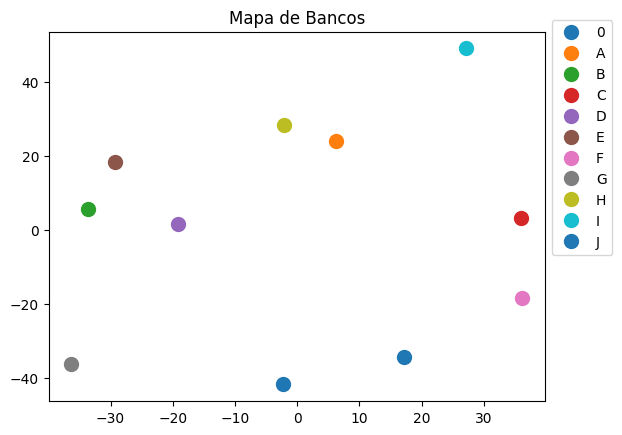

In [181]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

# Perform MDS to estimate the positions of the banks
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
positions = mds.fit_transform(distances)

# Print the estimated positions of the banks
dist = dict()

for i in range(distances.shape[0]):
    label = distances.index[i]
    x = positions[i,0]
    y = positions[i,1]
    dist[label] = (x, y)

# Create a plot
fig, ax = plt.subplots()

# Plot the banks as dots
for bank in dist:
    ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

# Add the legend
ax.legend(bbox_to_anchor=(1.15, 1.05))

# Add the title
plt.title("Mapa de Bancos")

# Show the plot
plt.show()

In [182]:
def get_connections(route):
  connections = list()
  for i in range(1, len(route)):
    connections.append((route[i-1], route[i]))

  return connections

In [183]:
def plot_route(route):
    casa_central = banks[0]

    # Create a plot
    fig, ax = plt.subplots()

    # Plot the banks as dots
    for bank in dist:
        ax.plot(dist[bank][0], dist[bank][1], 'o', markersize=10, label=bank)

    # Plot the connections as arrows
    for connection in get_connections(route):
        x1, y1 = dist[connection[0]]
        x2, y2 = dist[connection[1]]
        dx, dy = x2 - x1, y2 - y1

        if connection[1] == casa_central:
            color = 'black'
        else:
            cambio = int(capital.loc[connection[1]])
            if cambio > 0:
                color = 'green'
            else:
                color = 'red'

        ax.quiver(x1, y1, dx, dy,
                    angles='xy', scale_units='xy',
                    scale=1, width=0.003,
                    headwidth=15, color=color,
                    zorder=3)

    # Annotate the Casa Central
    ax.annotate('Casa Central', dist[casa_central])

    # Annotate the capital
    for b in banks[1:]:
        ax.annotate(int(capital.loc[b]), dist[b], weight="bold")

    # Add the legend
    ax.legend(bbox_to_anchor=(1.15, 1.05))

    # Add the title
    plt.title("Circuito del camión de caudales")

    # Show the plot
    plt.show()

### **3. Heurística de construcción.** Código y ejecución del algoritmo en algún lenguaje de programación eligiendo un conjunto de datos factibles.

Usamos la heurística de inserción más cercana pero teniendo en cuenta solo las inserciones que cumplen con las restricciones de capital.

In [184]:
def check_capital(route, capital):
    acumulado = 0
    for v in route:
        acumulado += capital.get(v, 0)
        if not (0 <= acumulado <= MAX_DINERO):
            return False
    return True

In [185]:
def insercion_mas_cercana(banks, distances, capital):
    # Comenzamos con un subtour con únicamente la sucursal inicial
    path = [banks[0]]
    edges = [(0, banks[0], banks[0])]
    non_visited = set(banks[1:])
    total_cost = 0

    # Mientras queden ciudades sin agregar al tour
    while len(non_visited) > 0:
        best_new_edges = []
        best_insert = -1
        best_cost_diff = None
        # Buscamos entre todas las ciudades sin agregar
        for v in non_visited:
            # El reemplazo de arista
            for i in range(1, len(path) + 1):
                new_path = path.copy()
                new_path.insert(i, v)

                if not check_capital(new_path, capital):
                    continue

                c, u, w = edges[i - 1]
                cost_diff = distances[u][v] + distances[v][w] - c
                if best_cost_diff is None or cost_diff < best_cost_diff:
                    best_cost_diff = cost_diff
                    best_insert = i - 1
                    best_new_edges = [(distances[u][v], u, v), (distances[v][w], v, w)]

        assert best_cost_diff is not None
        new_v = best_new_edges[0][2]
        non_visited.remove(new_v)
        edges[best_insert] = best_new_edges[1]
        edges.insert(best_insert, best_new_edges[0])
        path = path[:i] + [new_v] + path[i:]
        total_cost += best_cost_diff

    path.append(banks[0])
    return path, total_cost

path, total_cost = insercion_mas_cercana(banks, distances, capital)

In [186]:
print(f"La solución dada por la heurística es: {' -> '.join(path)}")
print(f"La distancia total es: {total_cost} Kms")

La solución dada por la heurística es: 0 -> J -> C -> G -> F -> B -> D -> A -> I -> H -> E -> 0
La distancia total es: 331 Kms


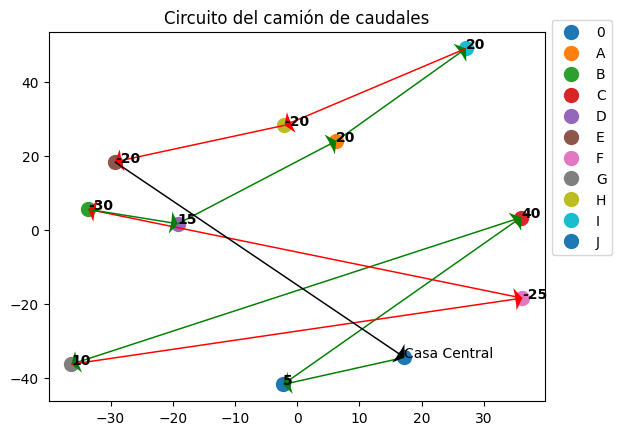

In [187]:
plot_route(path)

### **4. Heurística de mejoramiento.** Código y ejecución del algoritmo en algún lenguaje de programación experimentando con otro set de datos que represente un mayor desafío para la heurística.

Empezamos con una heurística de construcción, que crea una solución válida de la forma más simple.

In [188]:
from collections import deque

def gen_simple_route(banks, distances, capital):
    simple_route = [banks[0]]

    # Ordenamos las sucursales según su variación de capital,
    # empezando por las negativas y terminando con las positivas
    q = deque(sorted(banks[1:], key=lambda v: capital[v]))
    caja = 0
    i = 0

    # Mientras haya sucursales sin visitar:
    while len(q) > 0:
        initial_len = len(q)

        # Obtenemos la sucursal con mayor incremento de capital,
        # y la agregamos al camino si puede agregarse
        if 0 <= caja + capital[q[-i-1]] <= MAX_DINERO:
            caja += capital[q[-i-1]]
            simple_route.append(q.pop())

        # Ídem para la de mayor decremento
        if 0 <= caja + capital[q[i]] <= MAX_DINERO:
            caja += capital[q[i]]
            simple_route.append(q.popleft())

        # Si no hubo cambios, continuamos con el siguiente par
        if initial_len == len(q):
            i += 1
            assert i < (len(q) // 2 + 1)
        else:
            i = 0

    # Siempre vuelve al origen
    simple_route.append(banks[0])
    return simple_route

simple_route = gen_simple_route(banks, distances, capital)

Usamos la heurística de mejoramiento de K-Intercambios, con K=2 (o sea, 2-Opt), pero teniendo en cuenta que los nuevos caminos cumplan la restricción de capital.

In [189]:
def cost(distances, route):
    value = 0
    for i in range(1, len(route)):
        value += distances.loc[ route[i-1], route[i] ]

    return value

In [190]:
def two_opt(route, cost_mat, capital):
    best = route
    mejora = True

    while mejora:
        mejora = False
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)-1):
                if j-i == 1: continue
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
                if not check_capital(new_route, capital): continue
                if cost(cost_mat, new_route) < cost(cost_mat, best):
                    best = new_route
                    mejora = True
                    print('HUBO MEJORA!')
        route = best
    return best

In [191]:
costo_sin_mejorar = cost(distances, simple_route)
print(f"El camino sin mejorar es: {' -> '.join(simple_route)}")
print(f"La distancia total es: {costo_sin_mejorar} Kms")

El camino sin mejorar es: 0 -> C -> B -> I -> F -> A -> E -> D -> H -> G -> J -> 0
La distancia total es: 628 Kms


In [192]:
best_route = two_opt(simple_route, distances, capital)
best_route

HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!
HUBO MEJORA!


['0', 'C', 'F', 'D', 'A', 'H', 'I', 'E', 'B', 'G', 'J', '0']

In [193]:
costo_mejorado = cost(distances, best_route)
print(f"El camino mejorado es: {' -> '.join(best_route)}")
print(f"La distancia total es: {costo_mejorado} Kms")
print(f"La heurística cambia la distancia en: {costo_mejorado - costo_sin_mejorar} Kms")

El camino mejorado es: 0 -> C -> F -> D -> A -> H -> I -> E -> B -> G -> J -> 0
La distancia total es: 243 Kms
La heurística cambia la distancia en: -385 Kms


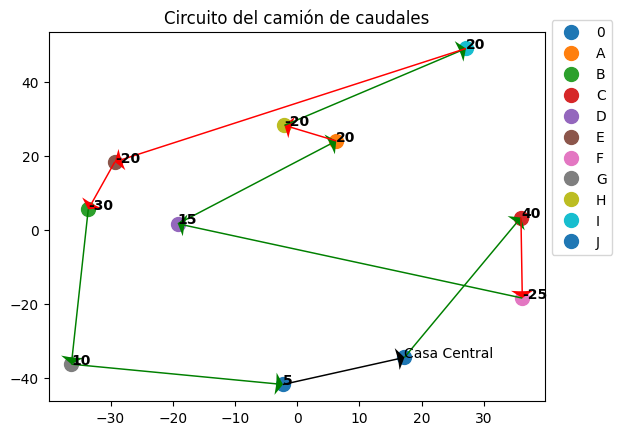

In [194]:
plot_route(best_route)

### **5. Comparación de resultados** entre modelos y heurísticas. Comparación con bibliografía estudiada. Conclusión.

Comparando los resultados, vemos que la heurística de construcción obtiene un buen resultado de **331 Kms**. Esto es **88 Kms** por encima del óptimo (243 Kms), o sea, un **36 % más**. No parece mucho, pero comparando con la otra heurística de construcción, que tiene un resultado de **628 Kms**, da un resultado con la mitad de distancia. Sin embargo, aplicando una heurística de mejoramiento, este último resultado mejora a **243 Kms** (el óptimo).

De todas formas, este ejemplo puede ser muy pequeño como para que se justifique usar una heurística. Por este motivo, a continuación se muestra un ejemplo con 30 sucursales, distribuidas a lo largo y ancho del globo.

In [195]:
!pip install geopandas==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [196]:
request.urlretrieve("https://raw.githubusercontent.com/gabokatta/modelos-tp1/main/project/ganancias_hard.csv", "ganancias_hard.csv")
request.urlretrieve("https://raw.githubusercontent.com/gabokatta/modelos-tp1/main/project/distancias_hard.csv", "distancias_hard.csv")
request.urlretrieve("https://raw.githubusercontent.com/gabokatta/modelos-tp1/main/project/distancias_hard_names.txt", "names_hard.txt")
request.urlretrieve("https://raw.githubusercontent.com/gabokatta/modelos-tp1/main/project/distancias_hard_coordenadas.csv", "coordenadas_hard.csv")

('coordenadas_hard.csv', <http.client.HTTPMessage at 0x7fa29bb39270>)

In [197]:
coordenadas = pd.read_csv('coordenadas_hard.csv', index_col=0)
ciudades = pd.read_csv('names_hard.txt', header=None)[0]
distances_hard = pd.read_csv('distancias_hard.csv', header=None)
distances_hard.columns = ciudades
distances_hard.columns
distances_hard.index = ciudades
capital_hard = pd.read_csv('ganancias_hard.csv', header=None)[0]
capital_hard.index = ciudades[1:]
capital_hard

0
Baghdad           40
Berlin           -20
Bombay            30
Buenos Aires     -15
Cairo            -50
Capetown         -10
Chicago           20
Guam               5
Honolulu          10
Istanbul          30
Juneau           -40
London           -20
Manila            -5
Melbourne         10
Mexico City       20
Montreal          35
Moscow           -45
New Orleans       10
New York          55
Panama City      -50
Paris            -20
Rio de Janeiro   -10
Rome               5
San Francisco     15
Santiago          20
Seattle           25
Shanghai         -30
Sydney            35
Tokyo            -35
Name: 0, dtype: int64

In [198]:
MAX_DINERO = 60
MAX_DINERO

60

In [199]:
M = int(capital_hard.abs().sum())
M

715

In [200]:
# Verificar que las distancias son simétricas
for i in range(len(distances)):
    for j in range(len(distances)):
        assert distances.iloc[i][j] == distances.iloc[j][i], f"{i}, {j}"

# Verificar que la suma de los capitales no es inválida
assert 0 <= sum(capital) <= MAX_DINERO

In [201]:
import geopandas as gpd
from matplotlib import pyplot as plt

df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<ipython-input-201-1f2562041e8f>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [202]:
def plot_map(route, dist):
    df_world.plot(figsize=(20,20))

    # Plot the banks as dots
    for city in range(len(coordenadas.index)):
        plt.plot(coordenadas.iloc[city]['longitude'], coordenadas.iloc[city]['latitude'], 'o',
                markersize=10, label=coordenadas.index[city])

    ax = plt.gca()

    # Plot the connections as arrows
    for connection in get_connections(route):
        y1, x1 = coordenadas.loc[connection[0]]
        y2, x2 = coordenadas.loc[connection[1]]
        dx, dy = x2 - x1, y2 - y1

        if connection[1] == route[0]:
            color = 'black'
        else:
            cambio = int(capital_hard[connection[1]])
            if cambio > 0:
                color = 'green'
            else:
                color = 'red'

        ax.quiver(x1, y1, dx, dy,
                    angles='xy', scale_units='xy',
                    scale=1, width=0.002,
                    headwidth=5, color=color,
                    zorder=3)

    # Annotate the capital
    for b in ciudades[1:]:
        ax.annotate(int(capital_hard[b]), coordenadas.loc[b][::-1], weight="bold")

    plt.legend(bbox_to_anchor=(1.15, 1.05))
    # Show the plot
    plt.show()

### Heurística de construcción

Costo total: 964


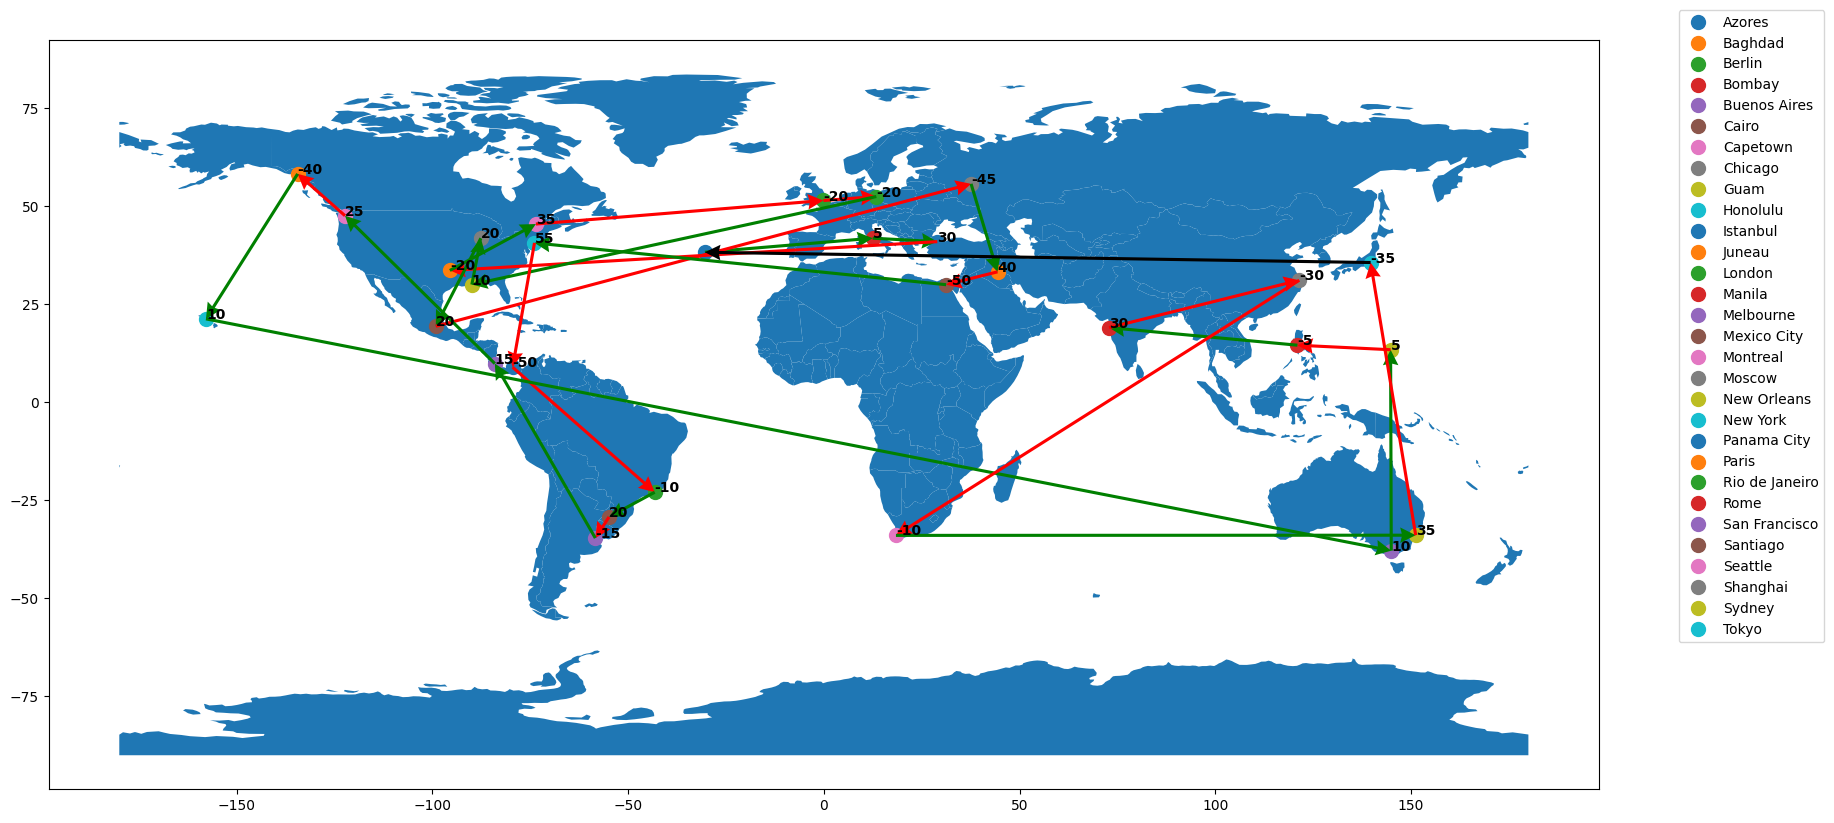

In [203]:
route, total_cost = insercion_mas_cercana(ciudades, distances_hard, capital_hard)
print("Costo total:", total_cost)
plot_map(route, distances_hard)

### Heurística de construcción simple

Costo total: 1804


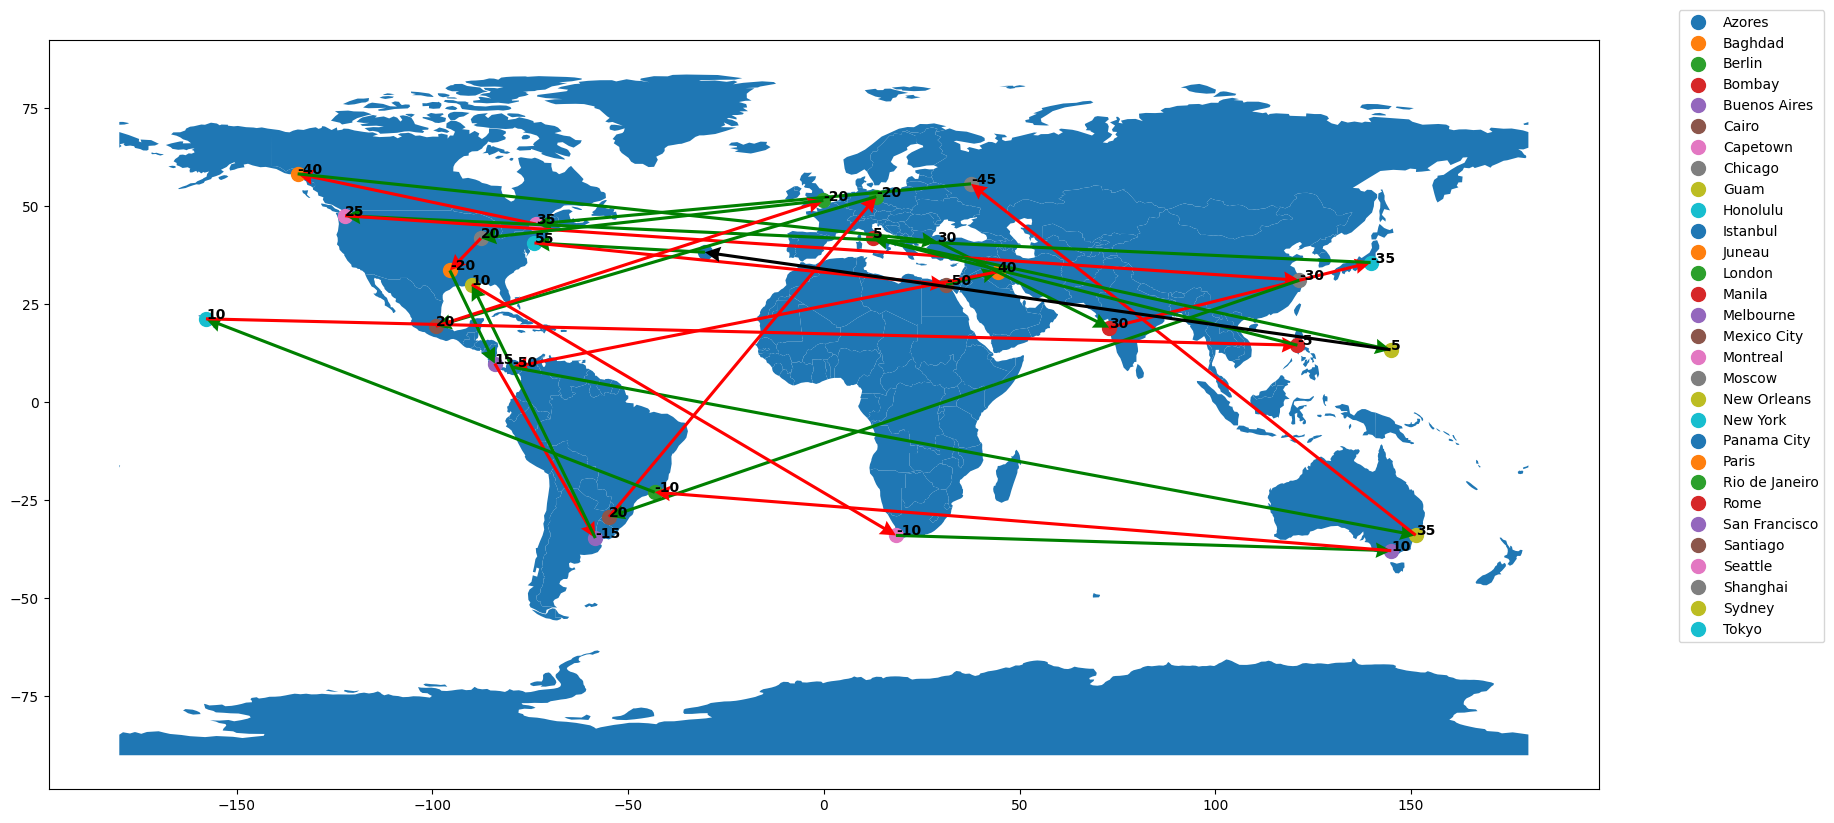

In [204]:
simple_route = gen_simple_route(ciudades, distances_hard, capital_hard)
print("Costo total:", cost(distances_hard, simple_route))
plot_map(simple_route, distances_hard)

### Heurística de mejoramiento

Como puede verse, la heurística no logró mejorar la solución anterior. Esto se debe a que ningún intercambio de dos aristas cumple con las restricciones de capital.

Costo total: 1804


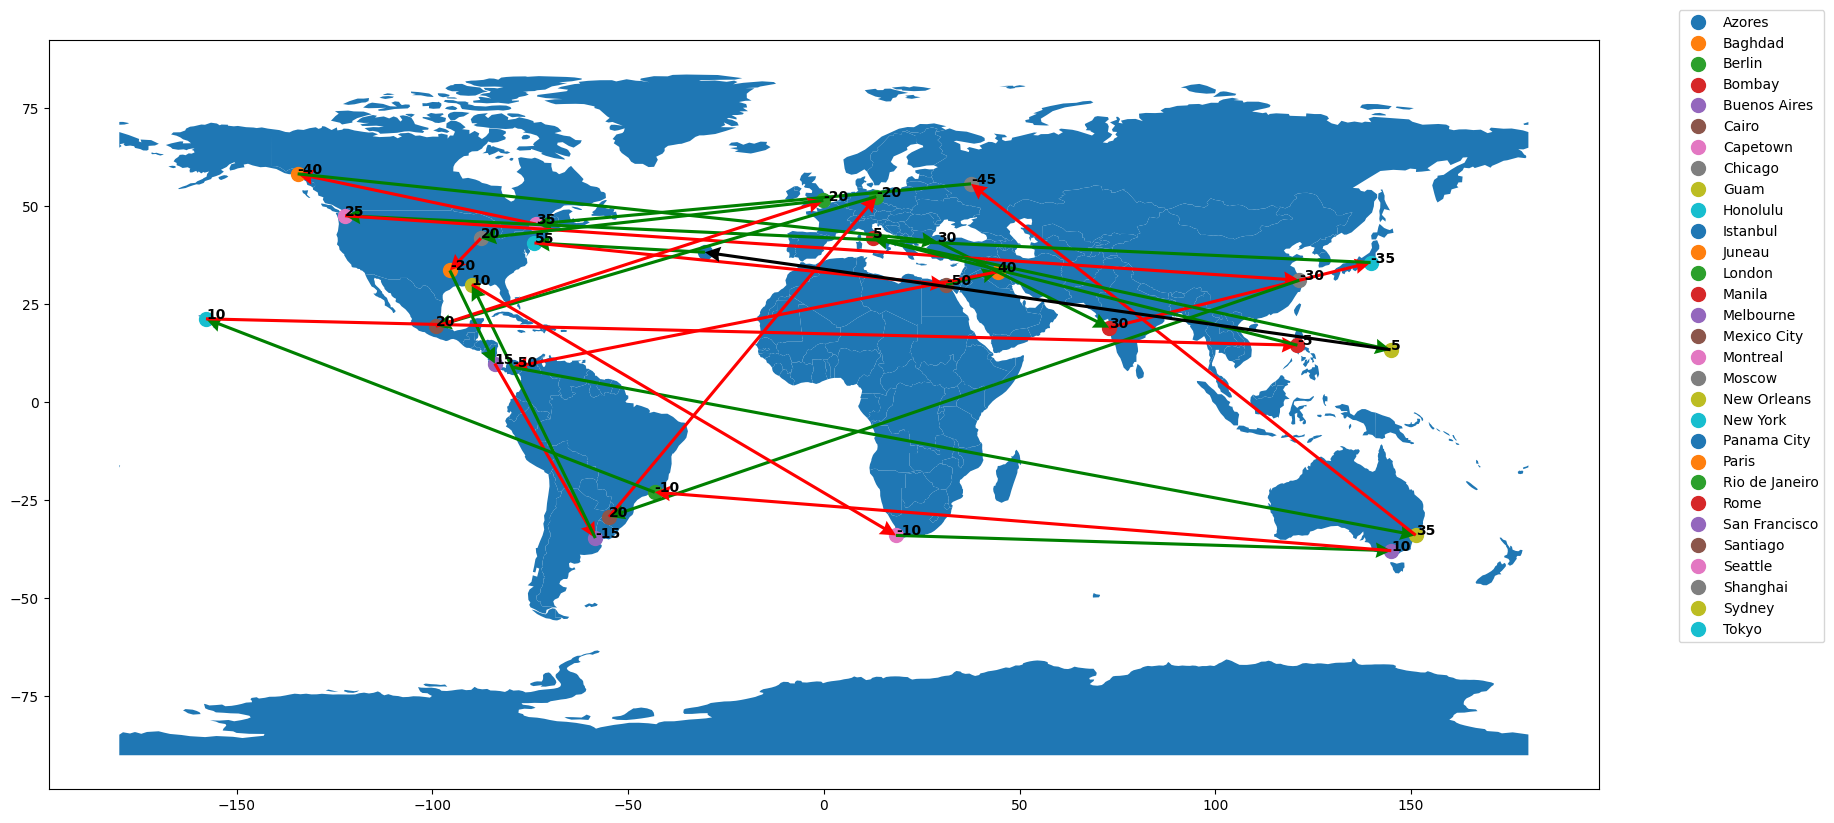

In [205]:
route = two_opt(simple_route, distances_hard, capital_hard)
print("Costo total:", cost(distances_hard, route))
plot_map(route, distances_hard)

## Conclusión

En este caso la heurística de construcción consiguió un mejor resultado que la de mejoramiento, pues esta última tiene problemas con la restricción de capital.